## **Data source**

https://www.kaggle.com/sulianova/cardiovascular-disease-dataset#cardio_train.csv

## Import packages

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import parallel_coordinates

%matplotlib inline

## Data acquisition and prep

In [3]:
data = pd.read_table('/Users/ericabadger/Downloads/cardio_train.csv', sep = ';')

In [4]:
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


**Columns**

- id    ID number
- age   in days
- gender   1 - women, 2 - men
- height   cm
- weight   kg
- ap_hi   Systolic blood pressure
- ap_lo   Diastolic blood pressure
- cholesterol   1: normal, 2: above normal, 3: well above normal
- gluc   1: normal, 2: above normal, 3: well above normal
- smoke   whether patient smokes or not
- alco   Binary feature
- active   Binary feature
- cardio   Target variable

### Check for nulls

In [5]:
# check for nulls
data[data.isnull().any(axis=1)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


### Convert from metric to imperial

In [58]:
# add variable to make age in years 
data['age_yrs'] = data['age']/365

# add variable to make height in inches
data['height_in'] = data['height'] / 2.54

# add variable to convert weight to pounds
data['weight_lb'] = data['weight'] * 2.2

In [59]:
# summary stats
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,height_in,weight_lb
count,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000
mean,49969.893243,19470.150026,1.349845,164.452463,74.253697,129.101727,96.680635,1.367492,1.226821,0.088334,0.053860,0.803817,0.500014,53.342877,64.745064,163.358133
std,28854.199371,2466.191542,0.476924,7.858600,14.314437,154.164119,188.678257,0.680783,0.572679,0.283782,0.225743,0.397112,0.500004,6.756689,3.093937,31.491761
min,0.000000,10798.000000,1.000000,122.000000,41.000000,60.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.583562,48.031496,90.200000
25%,24996.750000,17666.750000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.402055,62.598425,143.000000
50%,49997.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,53.980822,64.960630,158.400000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.430137,66.929134,180.400000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.967123,98.425197,440.000000


### Filtering

In [60]:
# filter data for illogical values
height_filter = data['height_in'] >= 48

weight_filter = data['weight_lb'] >= 90

ap_hi_filter = data['ap_hi'] >= 50

ap_lo_filter = data['ap_lo'] >= 30

before_filter = data.shape[0]

data = data[height_filter & weight_filter & ap_hi_filter & ap_lo_filter]

after_filter = data.shape[0]

print(before_filter)
print(after_filter)
print(before_filter - after_filter)


69588
69588
0


In [61]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,height_in,weight_lb
count,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000,69588.000000
mean,49969.893243,19470.150026,1.349845,164.452463,74.253697,129.101727,96.680635,1.367492,1.226821,0.088334,0.053860,0.803817,0.500014,53.342877,64.745064,163.358133
std,28854.199371,2466.191542,0.476924,7.858600,14.314437,154.164119,188.678257,0.680783,0.572679,0.283782,0.225743,0.397112,0.500004,6.756689,3.093937,31.491761
min,0.000000,10798.000000,1.000000,122.000000,41.000000,60.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.583562,48.031496,90.200000
25%,24996.750000,17666.750000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.402055,62.598425,143.000000
50%,49997.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,53.980822,64.960630,158.400000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.430137,66.929134,180.400000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.967123,98.425197,440.000000


### Look for and address highly correlated features

In [62]:
# Look at correlations between continuous variables
data_cont = data[['age','height','weight','ap_hi','ap_lo']].copy()

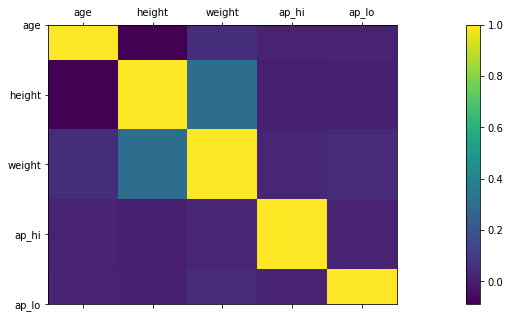

In [63]:
data_cont.corr()

plt.matshow(data_cont.corr())
plt.xticks(range(len(data_cont.columns)), data_cont.columns)
plt.yticks(range(len(data_cont.columns)), data_cont.columns)
plt.colorbar()
plt.gcf().set_size_inches(25, 5)

plt.show()

In [64]:
# add clinical variables for highly correlated measures

# BMI : Weight (LBS) x 703 ÷ Height (Inches²)
data['bmi'] = (data['weight_lb'] * 703) / (data['height_in']**2)

# Mean Arterial Pressure (MAP): ((2 * DP) + SP) / 3
data['map'] = ((2 * data['ap_lo']) + data['ap_hi']) / 3

data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_yrs,height_in,weight_lb,bmi,map
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.391781,66.141732,136.4,21.918890,90.000000
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.419178,61.417323,187.0,34.850994,106.666667
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.663014,64.960630,140.8,23.456193,90.000000
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.282192,66.535433,180.4,28.647444,116.666667
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.873973,61.417323,123.2,22.960655,73.333333


### Final data set

In [146]:
data2 = data[['age','gender','cholesterol','gluc','smoke','alco','active','cardio','bmi','map']].copy()
#data2.head()

## Classification

In [147]:
# make the heart disease label
y = data2[['cardio']].copy()

In [67]:
# specify the features to use
cardio_features = ['age','gender','cholesterol','gluc','smoke',
        'alco','active','bmi','map']

In [68]:
x = data[cardio_features].copy()

In [69]:
# Check the column names
y.columns

Index(['cardio'], dtype='object')

In [70]:
x.columns

Index(['age', 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active',
       'bmi', 'map'],
      dtype='object')

In [80]:
# create the test and train datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=777)

In [81]:
# fit the model on the train set
cardio_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
cardio_classifier.fit(x_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [82]:
# predict on the test set
predictions = cardio_classifier.predict(x_test)

In [83]:
# check predicted vs. actual for 100 values
predictions[:100]

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0])

In [84]:
y_test['cardio'][:100]

2046     0
15141    1
14535    0
55832    1
61032    1
        ..
16625    1
30421    0
6411     1
27639    1
38023    0
Name: cardio, Length: 100, dtype: int64

In [85]:
# Check the accuracy of the model
accuracy_score(y_true = y_test, y_pred = predictions)

0.7250163291966035

## Clustering

For the people with heart disease, try to cluster them into groups to see how they are related.  This could help with designing programs to target each cluster's specific needs when it comes to health promotion.

In [89]:
# First, limit data to only people with heart disease.
patients = data2.copy()

before_filter = patients.shape[0]

heart_disease = patients['cardio'] == 1

patients = patients[heart_disease]

after_filter = patients.shape[0]

print(before_filter)
print(after_filter)
print(before_filter - after_filter)

69588
34795
34793


For features, use cardio_features already established above.  Create a new dataframe containing only these features.


In [90]:
select_df = patients[cardio_features]
select_df.head()

,age,gender,cholesterol,gluc,smoke,alco,active,bmi,map
1,20228,1,3,1,0,0,1,34.850994,106.666667
2,18857,1,3,1,0,0,0,23.456193,90.000000
3,17623,2,1,1,0,0,1,28.647444,116.666667
7,22584,2,3,3,0,0,1,29.917758,103.333333
15,16782,2,1,1,0,0,0,37.775182,93.333333


In [91]:
# scale the features so they are on normalized scales
X = StandardScaler().fit_transform(select_df)
X

array([[ 0.07390164, -0.73931179,  1.90789673, ...,  0.51607348,
         1.16919562, -0.07450624],
       [-0.51810583, -0.73931179,  1.90789673, ..., -1.93770854,
        -0.90910928, -0.17895935],
       [-1.05095573,  1.3526093 , -0.66692211, ...,  0.51607348,
         0.0377263 , -0.01183438],
       ...,
       [ 1.09857977, -0.73931179,  0.62048731, ...,  0.51607348,
         3.99823325, -0.07450624],
       [-0.42785815,  1.3526093 ,  1.90789673, ..., -1.93770854,
         0.51874445,  0.00905625],
       [ 1.02517257, -0.73931179, -0.66692211, ..., -1.93770854,
        -0.25550143, -0.1267328 ]])

In [92]:
# Set up the K means clustering
kmeans = KMeans(n_clusters= 5) # create a k means object with 5 clusters
model = kmeans.fit(X) # scaled dataframe we are fitting
print("model\n", model) # will be a k means object

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [93]:
# Centers of the clusters
centers = model.cluster_centers_


In [94]:
# Plot different pairs of dimensions
labels = kmeans.labels_

In [102]:
select_df2 = select_df.copy()
# select_df2.head()

In [103]:
select_df2['clusters'] = labels
# select_df2.head()

,age,gender,cholesterol,gluc,smoke,alco,active,bmi,map,clusters
1,20228,1,3,1,0,0,1,34.850994,106.666667,4
2,18857,1,3,1,0,0,0,23.456193,90.000000,2
3,17623,2,1,1,0,0,1,28.647444,116.666667,1
7,22584,2,3,3,0,0,1,29.917758,103.333333,4
15,16782,2,1,1,0,0,0,37.775182,93.333333,2


In [104]:
# add the cluster column to the feature list
# cardio_features.extend(['clusters'])
# cardio_features

['age',
 'gender',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'bmi',
 'map',
 'clusters']

In [131]:
print(select_df2[cardio_features].groupby(['clusters']).mean())

                   age    gender  cholesterol      gluc     smoke  alco  \
clusters                                                                  
0         20564.242993  1.235307     2.449141  2.706826  0.047468  0.00   
1         19873.791891  1.999601     1.344717  1.077392  0.164270  0.00   
2         19735.732084  1.683021     1.675303  1.326351  0.452591  1.00   
3         20066.934352  1.000000     1.374021  1.040382  0.013119  0.00   
4         19273.100000  1.350000     1.450000  1.400000  0.050000  0.15   

            active        bmi          map  
clusters                                    
0         0.789557  30.056903   116.413954  
1         0.779708  27.262022   117.424373  
2         0.828556  28.995670   122.444322  
3         0.791179  28.638399   113.648041  
4         0.900000  27.493610  5350.033333  


In [117]:
output_n = select_df2[['age','clusters']].groupby(['clusters'], as_index = False).count()

output_n

,clusters,age
0,0,2092
1,1,18247
2,2,6063
3,3,1817
4,4,6576


In [138]:
# percent in cluster 1
18247/ 34795

0.5244144273602529

### Plots

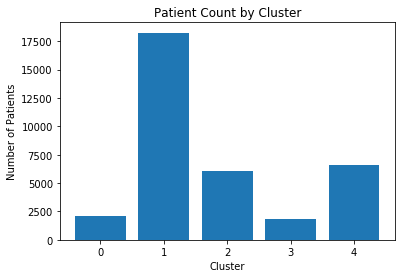

In [118]:
# Get the plot variables
clusters = output_n['clusters'].values
# get the values 
n = output_n['age'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')

#label the figure
plt.title('Patient Count by Cluster')


# create
plt.bar(clusters,n)
plt.show()



In [109]:
output = select_df2[cardio_features].groupby(['clusters'], as_index = False).mean()
output['age_yrs'] = output['age']/365
output

,clusters,age,gender,cholesterol,gluc,smoke,alco,active,bmi,map,age_yrs
0,0,19649.539197,1.851338,1.567400,1.269120,1.000000,0.0,0.808317,27.978445,122.277725,53.834354
1,1,19957.920480,1.308599,1.147038,1.042308,0.000000,0.0,1.000000,27.967330,118.555945,54.679234
2,2,20060.004783,1.320798,1.319809,1.126505,0.000000,0.0,0.000000,28.289592,111.908296,54.958917
3,3,19735.039626,1.682994,1.674739,1.326362,0.452394,1.0,0.828839,28.994345,131.903137,54.068602
4,4,20546.970955,1.258364,2.671229,2.061283,0.000912,0.0,0.917427,29.887076,119.807938,56.293071


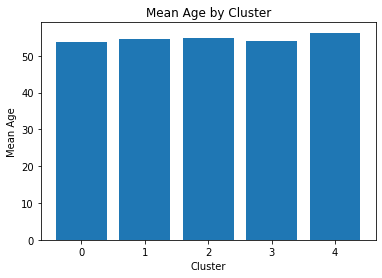

In [111]:
# Get the plot variables
clusters = output['clusters'].values
# get the values 
age = output['age_yrs'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Mean Age')

#label the figure
plt.title('Mean Age by Cluster')


# create
plt.bar(clusters,age)
plt.show()

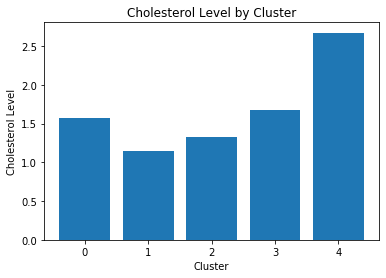

In [112]:
# Get the plot variables
clusters = output['clusters'].values
# get the values 
chol = output['cholesterol'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Cholesterol Level')

#label the figure
plt.title('Cholesterol Level by Cluster')


# create
plt.bar(clusters,chol)
plt.show()

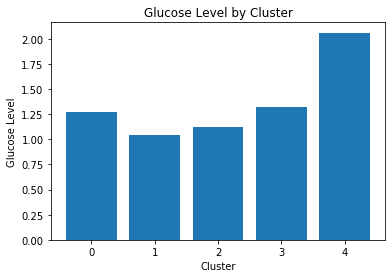

In [113]:
# Get the plot variables
clusters = output['clusters'].values
# get the values 
gluc = output['gluc'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Glucose Level')

#label the figure
plt.title('Glucose Level by Cluster')


# create
plt.bar(clusters,gluc)
plt.show()

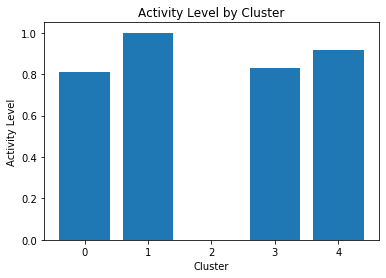

In [119]:
# Get the plot variables
clusters = output['clusters'].values
# get the values 
act = output['active'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Activity Level')

#label the figure
plt.title('Activity Level by Cluster')


# create
plt.bar(clusters,act)
plt.show()

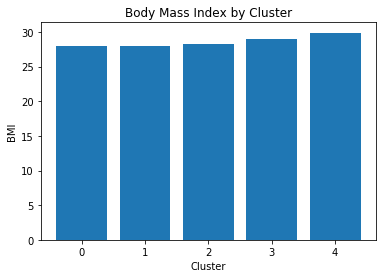

In [121]:
# Get the plot variables
clusters = output['clusters'].values
# get the values 
bmi = output['bmi'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('BMI')

#label the figure
plt.title('Body Mass Index by Cluster')


# create
plt.bar(clusters,bmi)
plt.show()

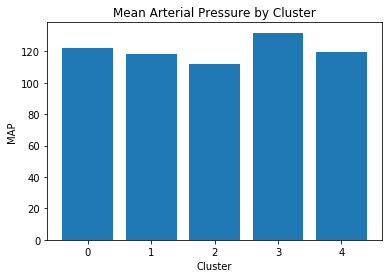

In [122]:
# Get the plot variables
clusters = output['clusters'].values
# get the values 
map = output['map'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('MAP')

#label the figure
plt.title('Mean Arterial Pressure by Cluster')


# create
plt.bar(clusters,map)
plt.show()

In [135]:
output_bin = select_df2[['clusters','smoke','alco']].groupby(['clusters'], as_index = False).agg({'smoke': ['sum','count'],
                                                                                                 'alco': ['sum','count']})

output_bin_cols = ['clusters','smoke','smoke_count','alco','total_count']

output_bin.columns = output_bin_cols

del output_bin['smoke_count']

output_bin['percent_smoke'] = output_bin['smoke'] / output_bin['total_count']

output_bin['percent_alco'] = output_bin['alco'] / output_bin['total_count']

output_bin


,clusters,smoke,alco,total_count,percent_smoke,percent_alco
0,0,2092,0,2092,1.000000,0.0
1,1,0,0,18247,0.000000,0.0
2,2,0,0,6063,0.000000,0.0
3,3,822,1817,1817,0.452394,1.0
4,4,6,0,6576,0.000912,0.0


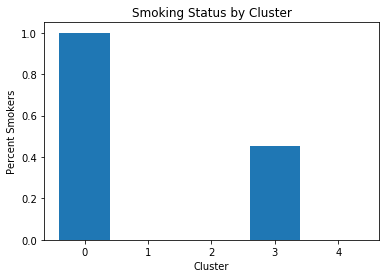

In [136]:
# Get the plot variables
clusters = output_bin['clusters'].values
# get the values 
smk = output_bin['percent_smoke'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Percent Smokers')

#label the figure
plt.title('Smoking Status by Cluster')


# create
plt.bar(clusters,smk)
plt.show()

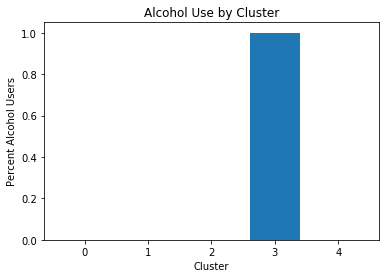

In [139]:
# Get the plot variables
clusters = output_bin['clusters'].values
# get the values 
alc = output_bin['percent_alco'].values

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Percent Alcohol Users')

#label the figure
plt.title('Alcohol Use by Cluster')


# create
plt.bar(clusters,alc)
plt.show()

Text(28.29117187499999, 0.5, 'MAP')

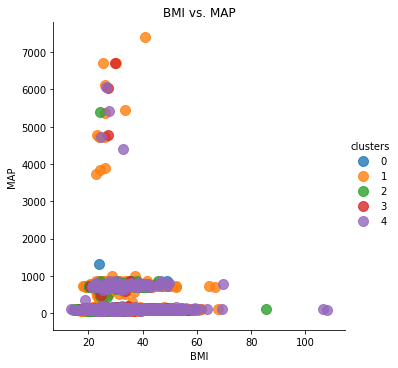

In [140]:
#Scatter plot 
from scipy import stats
import seaborn as sns


sns.lmplot('bmi', 'map', 
           data=select_df2, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('BMI vs. MAP')
plt.xlabel('BMI')
plt.ylabel('MAP')

Text(28.29117187499999, 0.5, 'MAP')

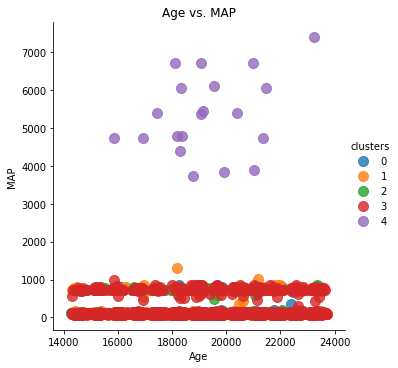

In [134]:
#Scatter plot 
from scipy import stats
import seaborn as sns


sns.lmplot('age', 'map', 
           data=select_df2, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Age vs. MAP')
plt.xlabel('Age')
plt.ylabel('MAP')

Text(27.468689236111118, 0.5, 'BMI')

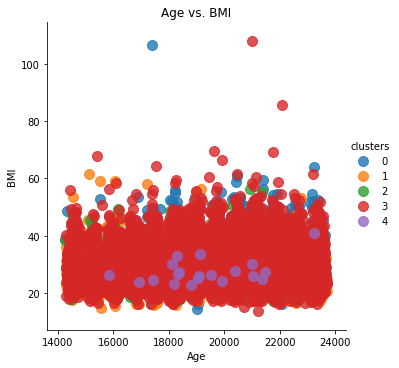

In [135]:
#Scatter plot 
from scipy import stats
import seaborn as sns


sns.lmplot('age', 'bmi', 
           data=select_df2, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Age vs. BMI')
plt.xlabel('Age')
plt.ylabel('BMI')

In [137]:
select_df2['clusters'].describe()

count    34795.000000
mean         1.991407
std          1.153685
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: clusters, dtype: float64

In [146]:
select_df2['pt_count'] = 1

select_df2[['clusters','pt_count']].groupby(['clusters']).sum()

,pt_count
clusters,
0,4424
1,10014
2,1814
3,18523
4,20


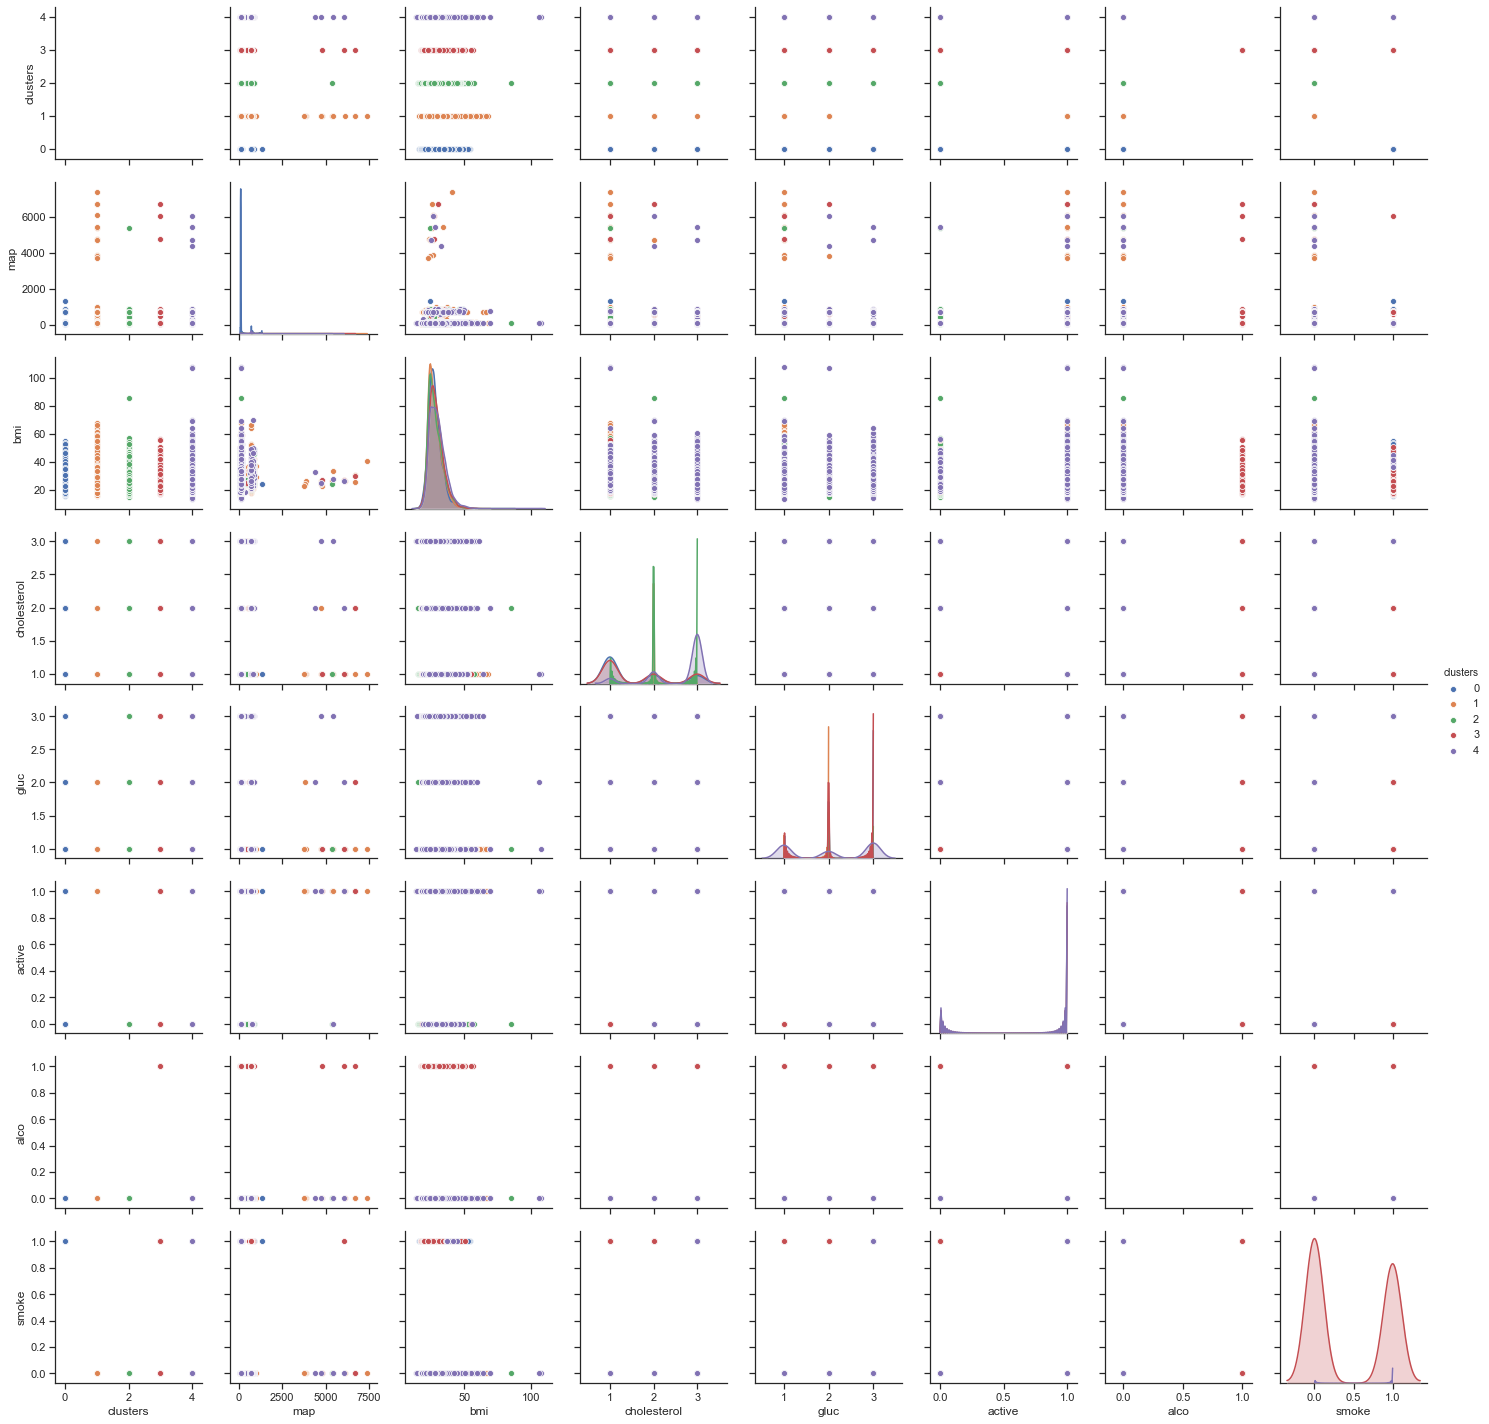

In [145]:
matrix = select_df2[['clusters','map','bmi','cholesterol','gluc','active','alco','smoke']].copy()

sns.set(style="ticks")

sns.pairplot(matrix, hue="clusters")